# All Imports

In [ ]:
!pip install ta

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from scipy.stats import skew
import ta
import kagglehub

# Modeling and preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb

# Model evaluation and metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score, auc,
    confusion_matrix,
    roc_auc_score,
    auc,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve
)
# Model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    ParameterSampler
)

# All Constants

In [ ]:
download_dir = kagglehub.dataset_download("andrewmvd/sp-500-stocks")
print("Path to dataset files:", download_dir)

# Use the downloaded directory to construct the full paths to the CSV files
SNP500_COMPANIES_FILE_PATH = os.path.join(download_dir, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(download_dir, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(download_dir, 'sp500_stocks.csv')

Path to dataset files: /kaggle/input/sp-500-stocks


# Lode Data in data frame

In [ ]:
# The rest of your code to load the data remains the same
def load_sp500_data(sp500_companies, sp500_index, sp500_stocks):
    print("Loading all dataframe.")
    # Check file existence - This check is still useful to ensure the files are in the downloaded directory
    for file_path in [sp500_companies, sp500_index, sp500_stocks]:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
    return pd.read_csv(sp500_companies), pd.read_csv(sp500_index, parse_dates=["Date"]), pd.read_csv(sp500_stocks, parse_dates=["Date"])

df_sp500_companies, df_sp500_index, df_sp500_stocks = load_sp500_data(SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH)

Loading all dataframe.


# Feature Engineering

In [ ]:
def prepare_features(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    df['Lag_Close_1'] = df.groupby('Symbol')['Close'].shift(1)
    df['Lag_Return_1'] = df.groupby('Symbol')['Close'].pct_change(1)
    df['MA_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).mean())
    df['Std_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).std())
    df['Price_Diff'] = df['Close'] - df['Open']
    df['Volatility_Range'] = (df['High'] - df['Low']) / df['Close']
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)

    df = df.dropna(subset=[
        'Lag_Close_1', 'Lag_Return_1', 'MA_Return_5', 'Std_Return_5',
        'Price_Diff', 'Volatility_Range', 'DayOfWeek', 'Target_UpDown'
    ])

    return df

def de_index(df):
    print("\n Adding Month and Date for Index data.")
    df['Month'] = df['Date'].astype(str).str[:7]
    df['Year'] = df['Date'].astype(str).str[:4]
    df['Daily Return'] = (df['S&P500'] / df['S&P500'].shift(1)) - 1
    return df


def remove_empty_or_nan_rows(df, name="DataFrame"):
    print(f"\n ******************** Cleaning: {name} ********************")

    rows_before = df.shape[0]
    print(f"Rows before cleanup: {rows_before}")

    # Replace blank strings with NaN and drop rows with any NaN
    df_cleaned = df.replace(r'^\s*$', np.nan, regex=True)
    df_cleaned = df_cleaned.dropna(how='any')
    df_cleaned = df_cleaned.reset_index(drop=True)

    rows_after = df_cleaned.shape[0]
    print(f"Rows after cleanup: {rows_after}")

    # Calculate and print % of rows dropped
    rows_dropped = rows_before - rows_after
    percent_dropped = (rows_dropped / rows_before) * 100 if rows_before > 0 else 0
    print(f"Percentage of rows removed: {percent_dropped:.2f}%")

    return df_cleaned

def combine_comp_and_stock(stock, compeny):
     print("\n Combining Stock and compeny data. \n")
     return  pd.merge(
        stock,
        compeny,
        on="Symbol",
        how="inner"
    )



In [ ]:
df_sp500_index = de_index(df_sp500_index)


 Adding Month and Date for Index data.


# EDA

In [ ]:
def explore_columns_datatype(df, df_name="DataFrame"):
    print(f"\n *********************  Overview of {df_name} *********************")

    print("\nColumn Names:")
    print(list(df.columns))

    print("\nColumn Data Types:")
    print(df.dtypes)

    print("\nFirst 5 Rows:")
    print(df.head())


def explore_missing_values(df, df_name="DataFrame"):
    print(f"\n*********************   {df_name} *********************  \n")
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        "Missing Count": missing_counts,
        "Missing Percentage (%)": missing_percent.round(2)
    })

    print(missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Count", ascending=False))

def plot_correlation_matrix(df, df_name="DataFrame"):
    corr = df.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f'Correlation Matrix for {df_name}')
    plt.tight_layout()
    plt.show()

def plot_numerical_distributions(df, df_name="DataFrame"):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=50)
        plt.title(f'Distribution of {col} in {df_name}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_categorical_counts(df, df_name="DataFrame"):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(20)
        if not value_counts.empty:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Top Categories of {col} in {df_name}')
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def print_column_unique_value(df, columnName):
    print(f"\n Unique Value for {columnName}",df[columnName].unique())


def plot_exchange_distribution_bar(df):
    """
    Plots a bar chart showing count and percentage of stocks per exchange.
    """
    exchange_counts = df['Exchange'].value_counts()
    total = exchange_counts.sum()
    percentages = (exchange_counts / total) * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(exchange_counts.index, exchange_counts.values, color=plt.cm.Set2.colors)

    for bar, percentage, count in zip(bars, percentages, exchange_counts.values):
        height = bar.get_height()
        label = f'{percentage:.1f}%\n({count})'
        plt.text(bar.get_x() + bar.get_width() / 2, height, label,
                 ha='center', va='bottom', fontsize=10)

    plt.title('Stock Count and Percentage by Exchange', fontsize=14, weight='bold')
    plt.xlabel('Exchange')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.show()



def plot_category_pie_chart(df, column_name, title=None):
    """
    Plots a pie chart with counts and percentages for a given categorical column.
    """
    category_counts = df[column_name].value_counts()
    labels = [f"{cat} ({count})" for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(
        category_counts,
        labels=None,
        autopct=lambda pct: f"{pct:.1f}%",  # Show only % inside
        startangle=90,
        counterclock=False,
        pctdistance=0.85,
        colors=plt.cm.tab20.colors
    )

    ax.legend(
        wedges,
        labels,
        title=f'{column_name} (count)',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )

    ax.set_title(title if title else f'Distribution of {column_name}', pad=20, fontsize=14, weight='bold')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


def apply_log1p_transform(df, columns, inplace=True):
    if not inplace:
        df = df.copy()

    for col in columns:
        new_col = f"log1p_{col}"
        df[new_col] = np.log1p(df[col])

    return df

def visualize_log1p_transformation(df, column, log_column, title_prefix=""):
    plt.figure(figsize=(12, 6))

    sns.kdeplot(df[column].dropna(), label=f"Original {column}", fill=True, color='skyblue')
    sns.kdeplot(df[log_column].dropna(), label=f"Log1p Transformed {column}", fill=True, color='orange')

    plt.title(f"{title_prefix} Distribution: {column} vs {log_column}", fontsize=14, weight='bold')
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_sp500_performance(sp_500_index, num_years=None):
    if 'Year' not in sp_500_index.columns:
        sp_500_index['Year'] = sp_500_index['Date'].dt.year

    # Filter data based on year
    if num_years:
        latest_year = sp_500_index['Year'].max()
        filtered_df = sp_500_index[sp_500_index['Year'] >= (latest_year - num_years)]
    else:
        filtered_df = sp_500_index

    # Plot
    ax = filtered_df[['Date', 'S&P500']].set_index('Date').plot(figsize=(10, 8))
    plt.title("S&P 500 Index Performance", weight='bold', fontsize=15)
    ax.set_xlabel("Date", weight='bold', fontsize=13)
    ax.set_ylabel("Daily S&P 500 Index Price", weight='bold', fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_stock_performance_by_symbol(df, symbols, column='Close'):
    if 'Date' not in df.columns or 'Symbol' not in df.columns or column not in df.columns:
        raise ValueError(f"DataFrame must contain 'Date', 'Symbol', and '{column}' columns.")

    plt.figure(figsize=(14, 8))
    has_data = False

    for symbol in symbols:
        df_symbol = df[df['Symbol'] == symbol].copy()
        if df_symbol.empty:
            print(f"No data for symbol: {symbol}")
            continue

        df_symbol = df_symbol.sort_values('Date')
        plt.plot(df_symbol['Date'], df_symbol[column], label=symbol)
        has_data = True

    if has_data:
        plt.title(f'{column} Price Performance for Selected Stocks', fontsize=16, weight='bold')
        plt.xlabel('Date', fontsize=14, weight='bold')
        plt.ylabel(f'{column} Price', fontsize=14, weight='bold')
        plt.legend(title='Stock Symbol', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid data found for any of the provided symbols.")


def plot_index_vs_stock(df_stock, df_index, symbol):
    df_stock = df_stock[df_stock['Symbol'] == symbol].copy()
    df = pd.merge(df_stock, df_index, on='Date', how='inner')

    df['Normalized_Close'] = df['Close'] / df['Close'].iloc[0]
    df['Normalized_S&P500'] = df['S&P500'] / df['S&P500'].iloc[0]

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Normalized_Close'], label=f'{symbol} Stock')
    plt.plot(df['Date'], df['Normalized_S&P500'], label='S&P 500 Index')
    plt.title(f'Normalized {symbol} vs S&P 500 Index')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_return_comparison(df_stock, df_index, symbol):
    df_symbol = df_stock[df_stock['Symbol'] == symbol].copy()
    df_symbol = df_symbol[['Date', 'Close']].dropna()
    df_symbol['Date'] = pd.to_datetime(df_symbol['Date'])
    df_symbol = df_symbol.sort_values('Date')
    df_symbol['Return'] = df_symbol['Close'].pct_change()

    df_index = df_index.copy()
    df_index = df_index[['Date', 'S&P500']].dropna()
    df_index['Date'] = pd.to_datetime(df_index['Date'])
    df_index = df_index.sort_values('Date')
    df_index['Return'] = df_index['S&P500'].pct_change()

    # Merge on date
    df_merged = pd.merge(df_symbol, df_index, on='Date', how='inner', suffixes=('_stock', '_index'))

    plt.figure(figsize=(12, 6))
    plt.plot(df_merged['Date'], df_merged['Return_stock'], label=f'{symbol} Return', color='blue')
    plt.plot(df_merged['Date'], df_merged['Return_index'], label='S&P 500 Return', color='orange')
    plt.title(f'Daily Returns: {symbol} vs S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




## EDA on Raw data

In [ ]:
explore_columns_datatype(df_sp500_companies, "S&P500 Companies")
explore_columns_datatype(df_sp500_index, "S&P500 Index")
explore_columns_datatype(df_sp500_stocks, "S&P500 Stocks")

explore_missing_values(df_sp500_companies, "S&P500 Companies")
explore_missing_values(df_sp500_index, "S&P500 Index")
explore_missing_values(df_sp500_stocks, "S&P500 Stocks")




 *********************  Overview of S&P500 Companies *********************

Column Names:
['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Exchange                object
Symbol                  object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object

First 5 Rows:
  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     

In [ ]:
df_sp500_companies = remove_empty_or_nan_rows(df_sp500_companies, "S&P500 Companies")
df_sp500_index = remove_empty_or_nan_rows(df_sp500_index, "S&P500 Index")
df_sp500_stocks = remove_empty_or_nan_rows(df_sp500_stocks, "S&P500 Stocks")
df_companies_and_stock = combine_comp_and_stock(df_sp500_stocks, df_sp500_companies)
row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)
explore_columns_datatype(df_companies_and_stock, df_name="df_companies_and_stock DataFrame")


 ******************** Cleaning: S&P500 Companies ********************
Rows before cleanup: 502
Rows after cleanup: 443
Percentage of rows removed: 11.75%

 ******************** Cleaning: S&P500 Index ********************
Rows before cleanup: 2517
Rows after cleanup: 2516
Percentage of rows removed: 0.04%

 ******************** Cleaning: S&P500 Stocks ********************
Rows before cleanup: 1891536
Rows after cleanup: 617831
Percentage of rows removed: 67.34%

 Combining Stock and compeny data. 

df_companies_and_stock Row count: 540645

 *********************  Overview of df_companies_and_stock DataFrame *********************

Column Names:
['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Date                   datetime64[ns]
Symbol             

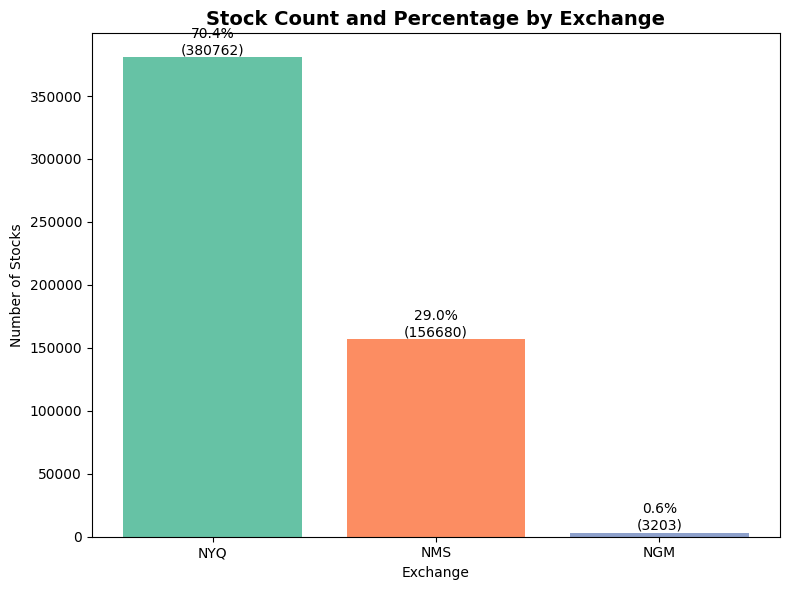

In [ ]:
plot_exchange_distribution_bar(df_companies_and_stock)


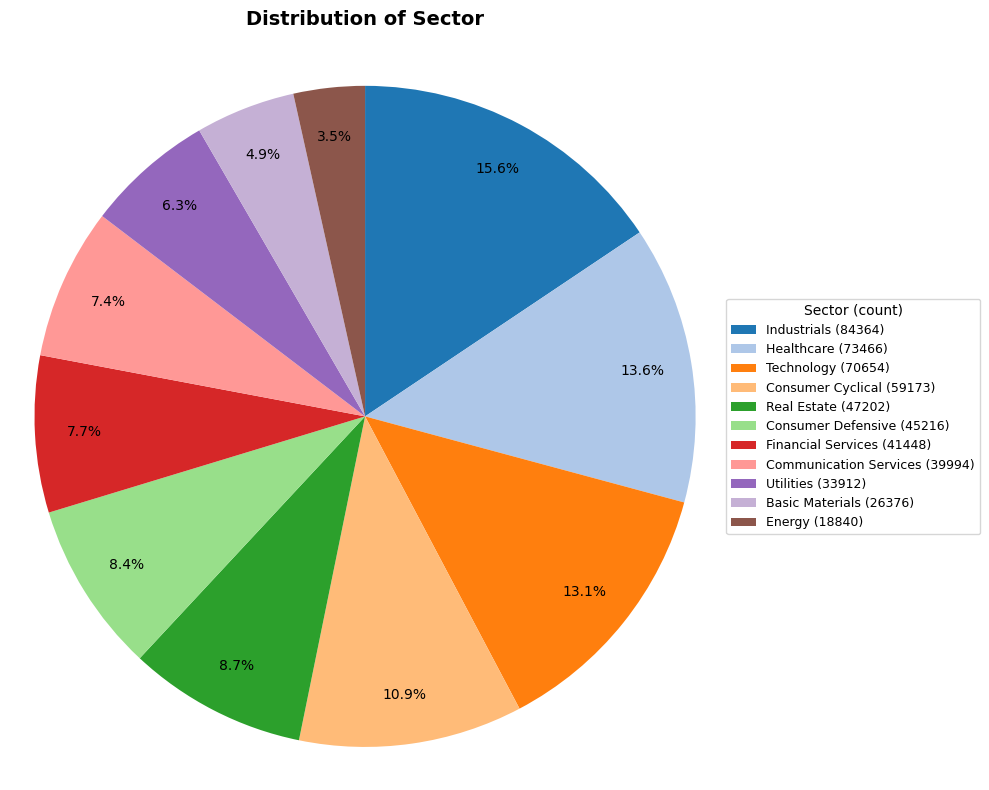

In [ ]:
plot_category_pie_chart(df_companies_and_stock, 'Sector')


/tmp/ipython-input-150-2177680750.py:116: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


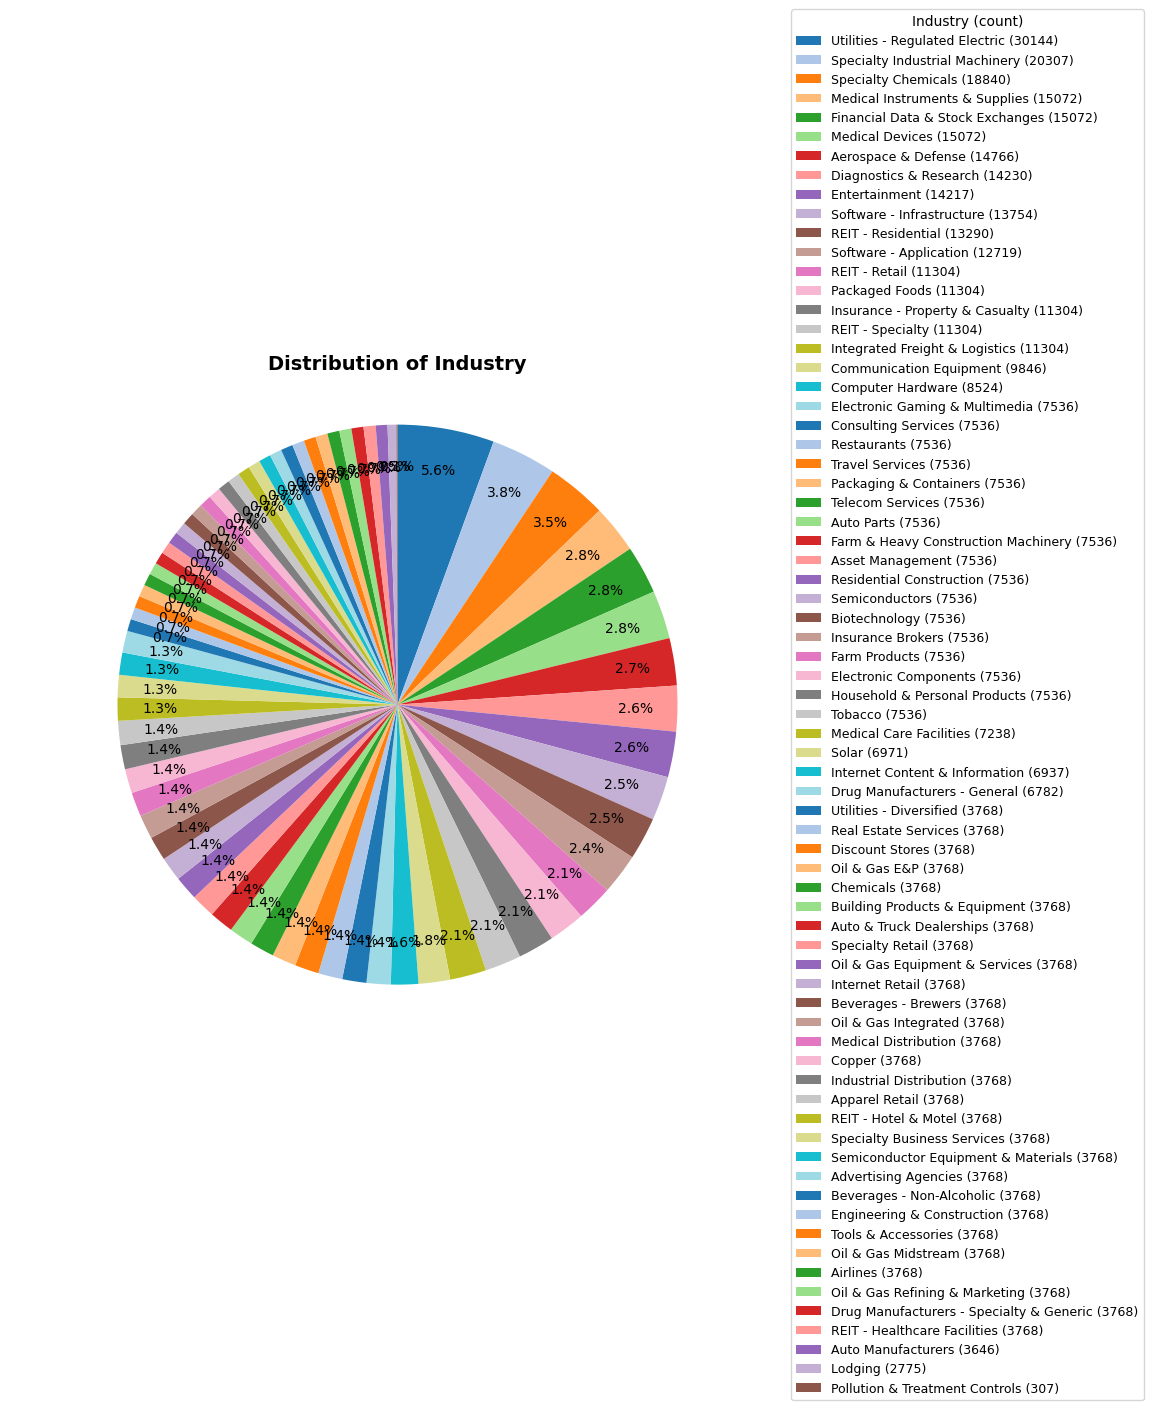

In [ ]:
plot_category_pie_chart(df_companies_and_stock, 'Industry') #To look better we can plot just for top 20 or 30


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


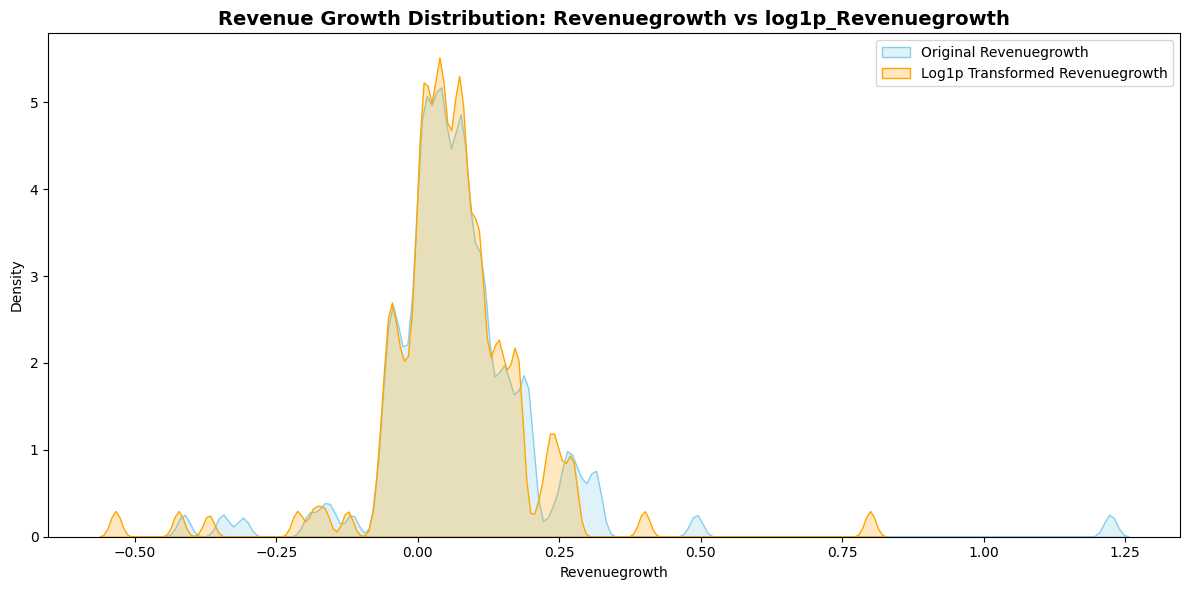

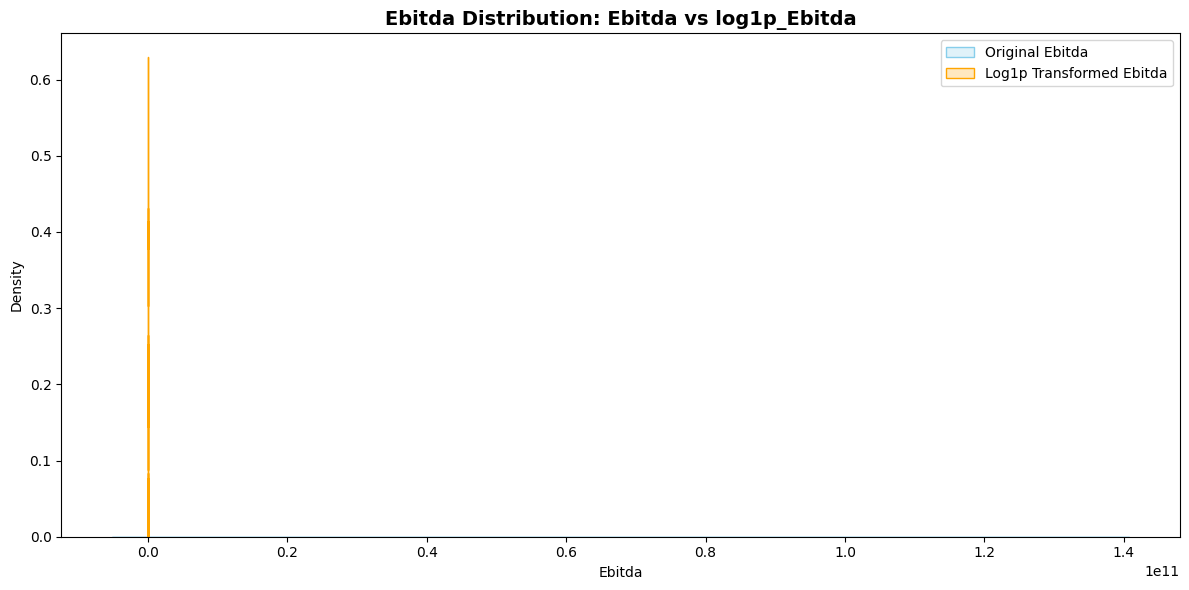

In [ ]:


df_companies_and_stock = apply_log1p_transform(df_companies_and_stock, ['Revenuegrowth', 'Ebitda'])
visualize_log1p_transformation(df_companies_and_stock, 'Revenuegrowth', 'log1p_Revenuegrowth', title_prefix="Revenue Growth")
visualize_log1p_transformation(df_companies_and_stock, 'Ebitda', 'log1p_Ebitda', title_prefix="Ebitda")


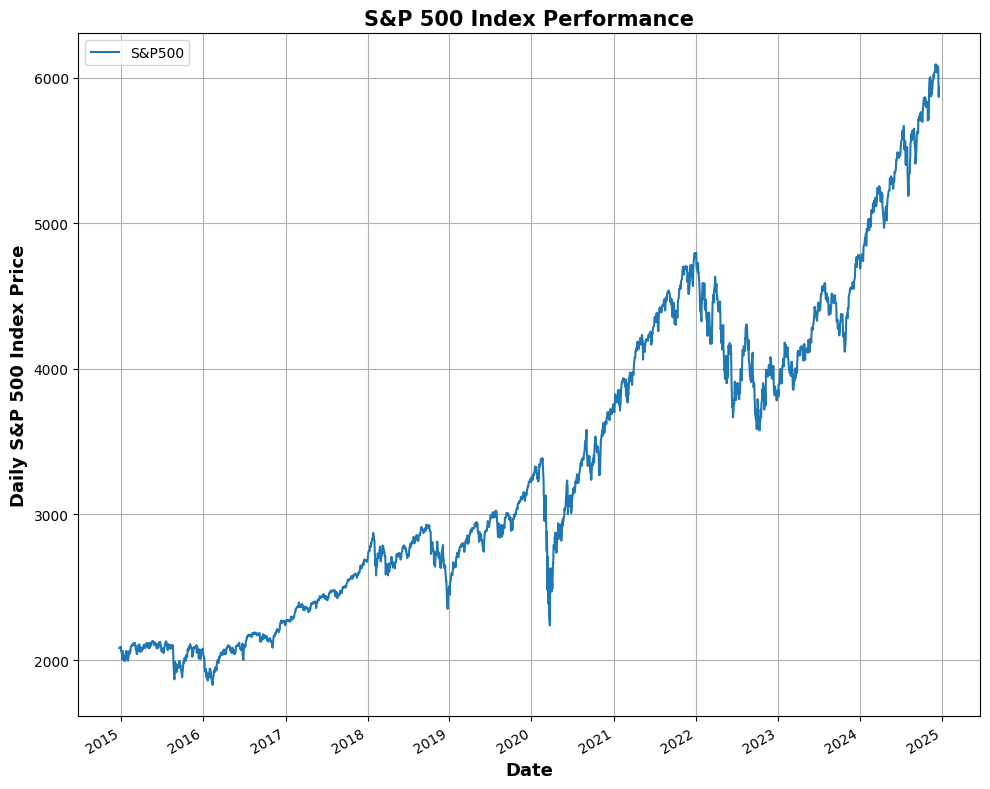

In [ ]:
plot_sp500_performance(df_sp500_index)

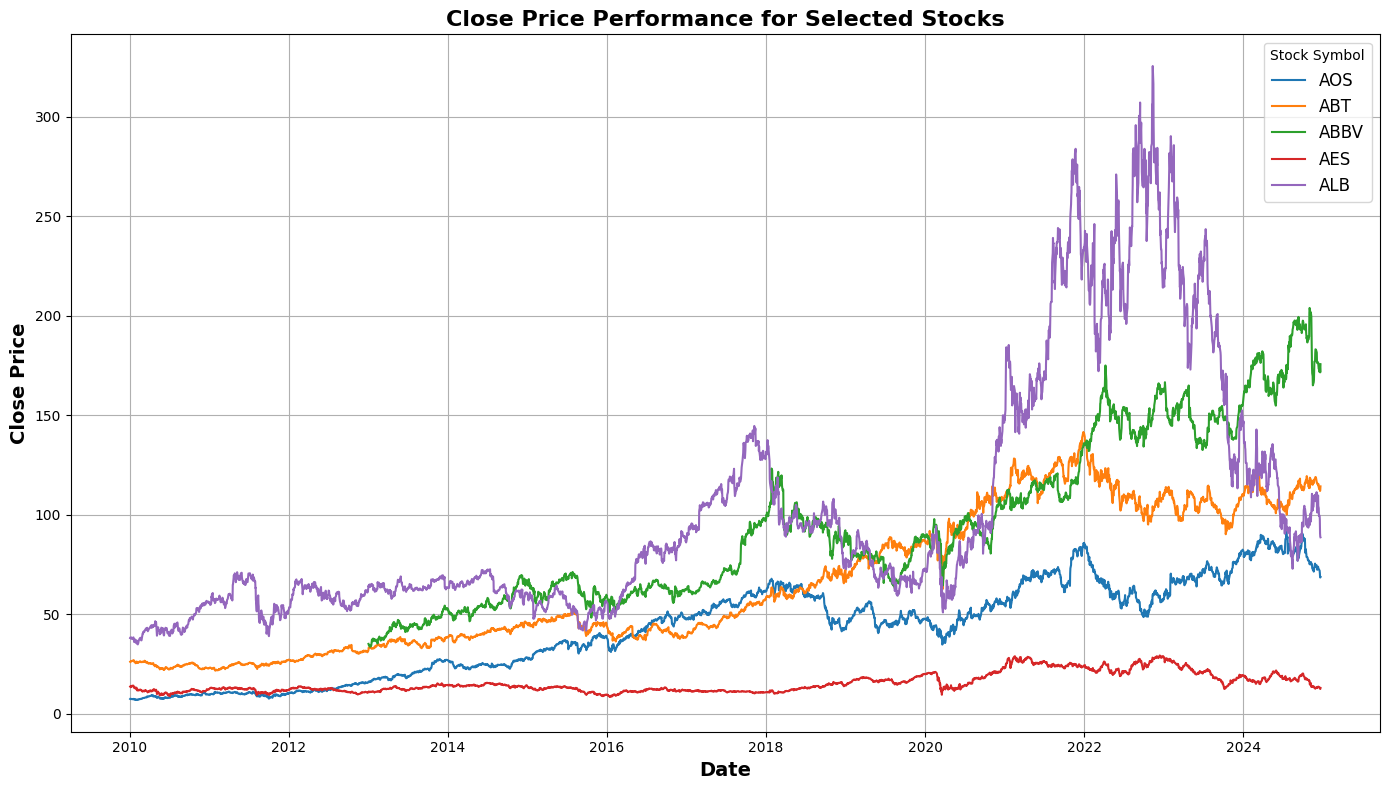

In [ ]:
#plot_stock_performance_by_symbol(df_companies_and_stock, ['AAPL', 'MSFT', 'GOOGL'])
plot_stock_performance_by_symbol(df_companies_and_stock, df_companies_and_stock['Symbol'].unique()[:5])


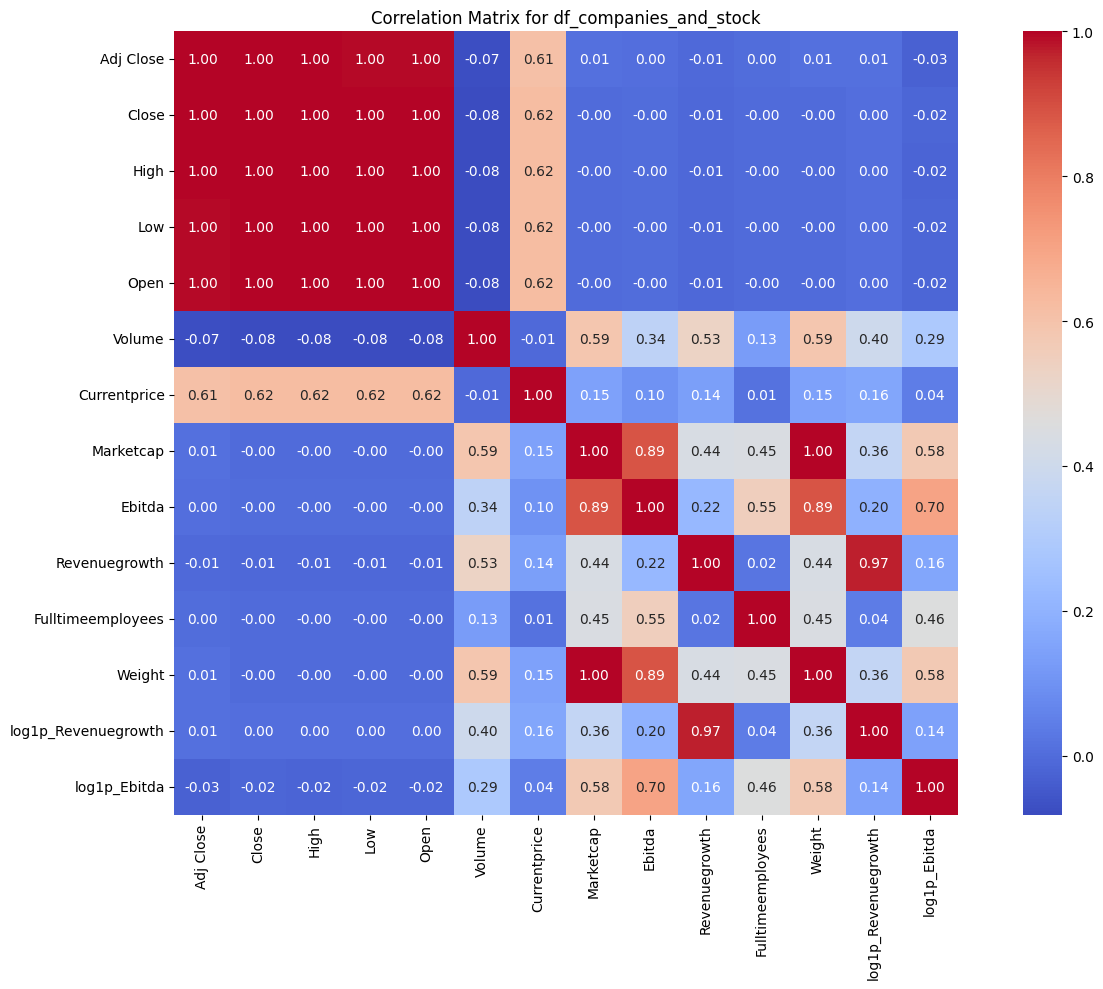

In [ ]:
plot_correlation_matrix(df_companies_and_stock, "df_companies_and_stock")


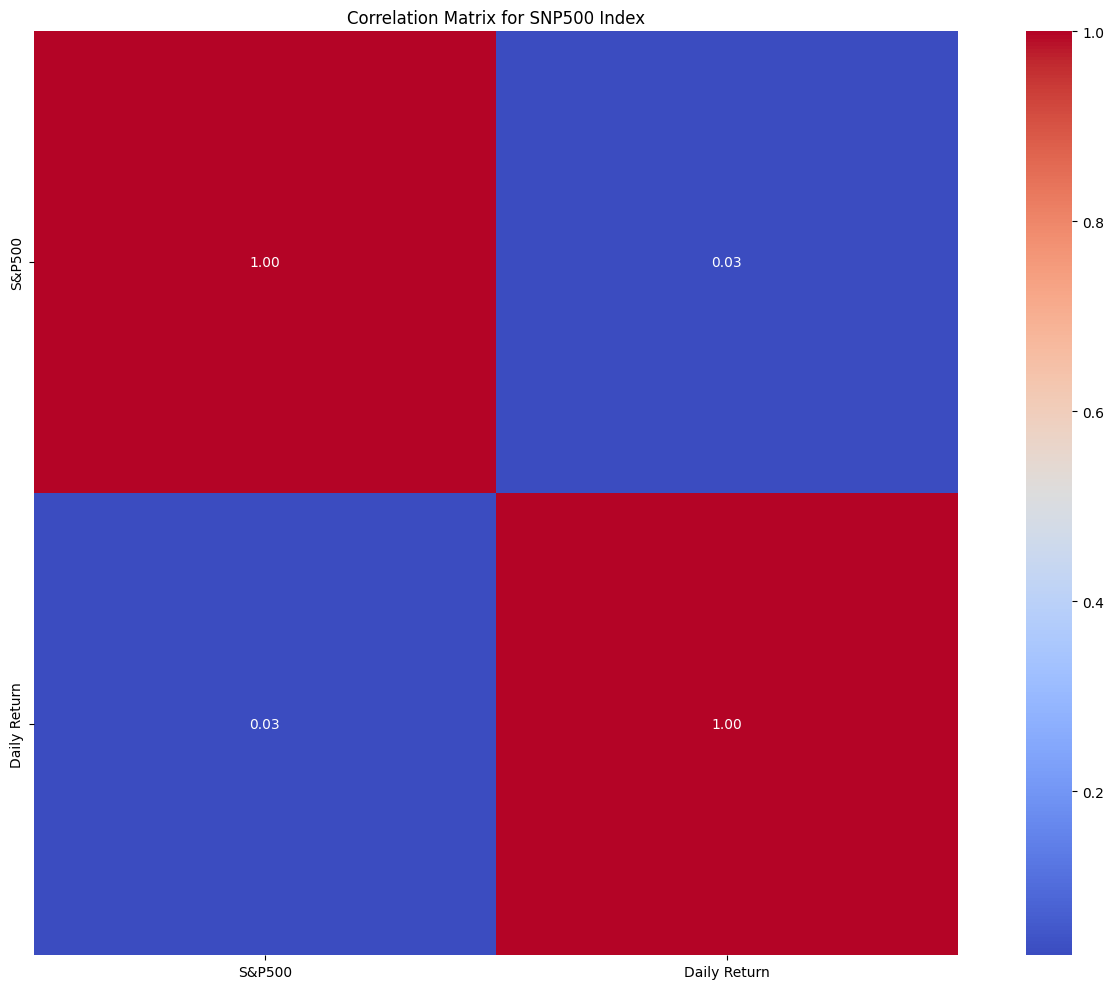

In [ ]:
plot_correlation_matrix(df_sp500_index, "SNP500 Index")


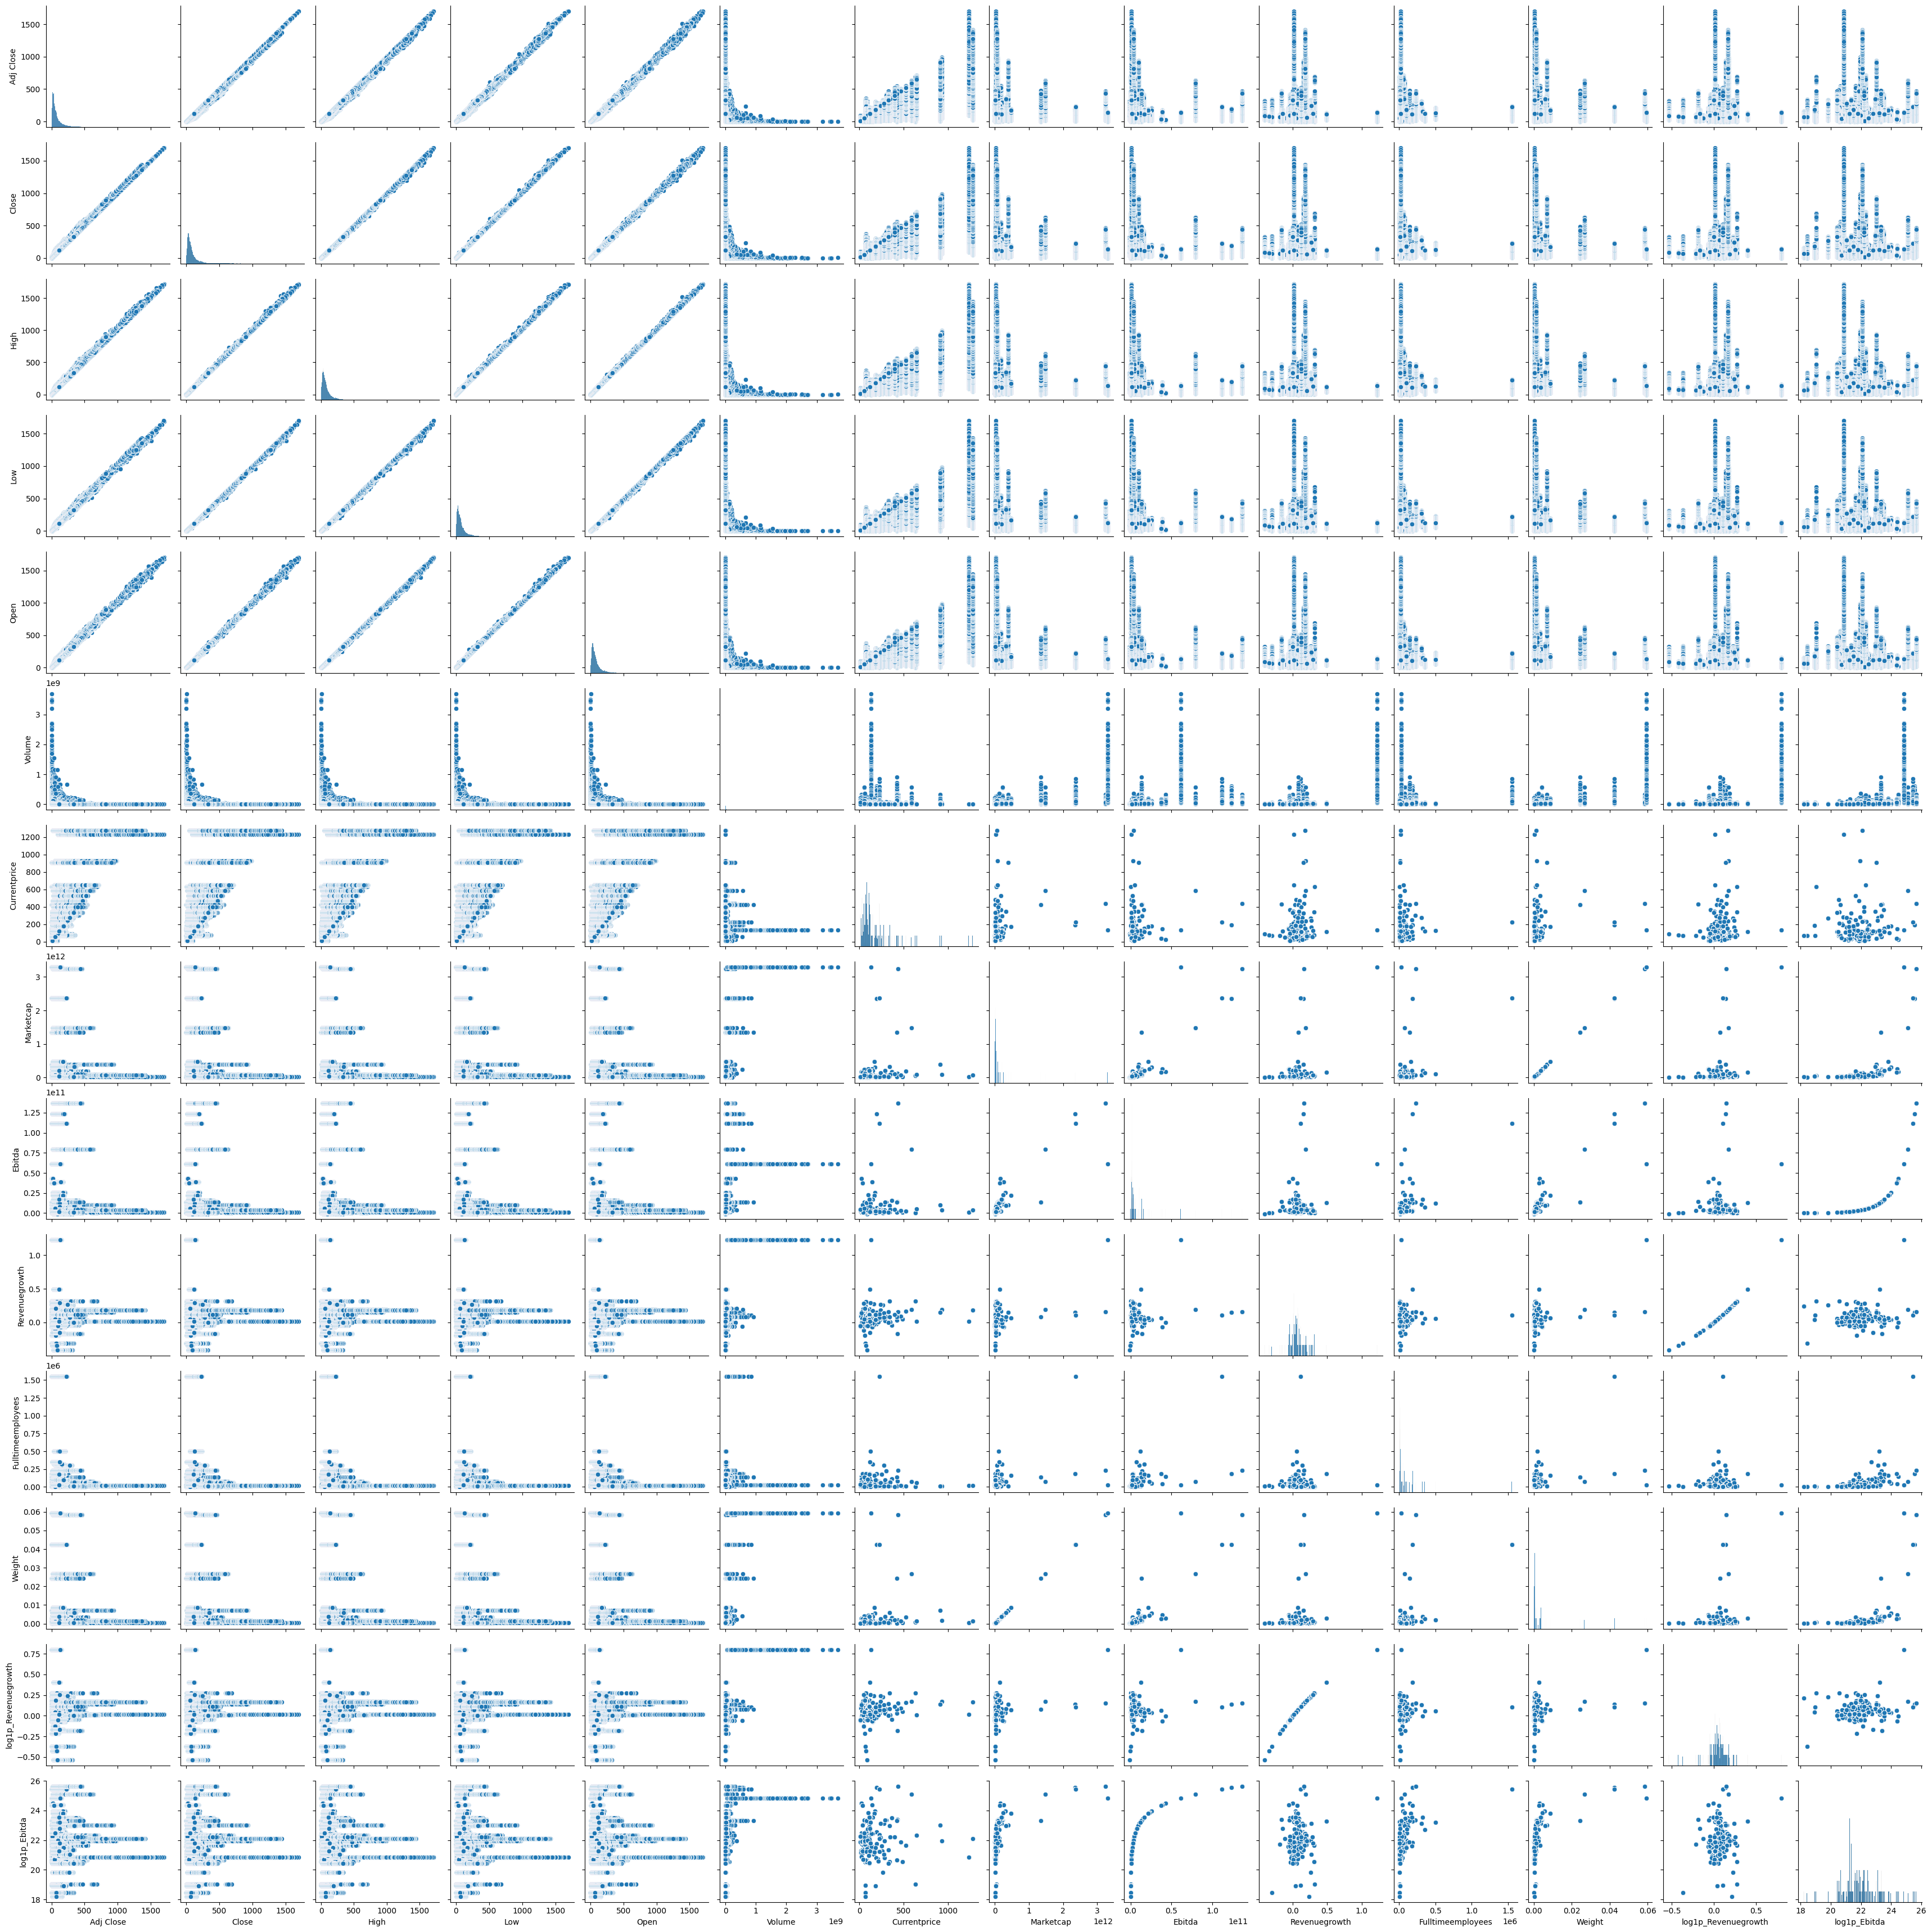

In [ ]:
sns.pairplot(df_companies_and_stock)
plt.show()

In [ ]:
#p = sns.PairGrid(df_companies_and_stock) # Calling pointplot for the entire dataframe
#p.map(sns.stripplot, jitter=True, size=3) # Adding jitter by specifying striplot

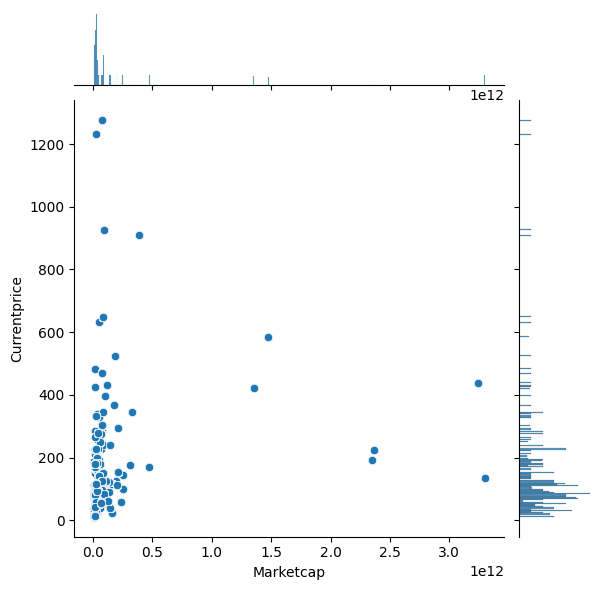

In [ ]:
sns.jointplot(data=df_companies_and_stock, x='Marketcap', y='Currentprice', kind='scatter')

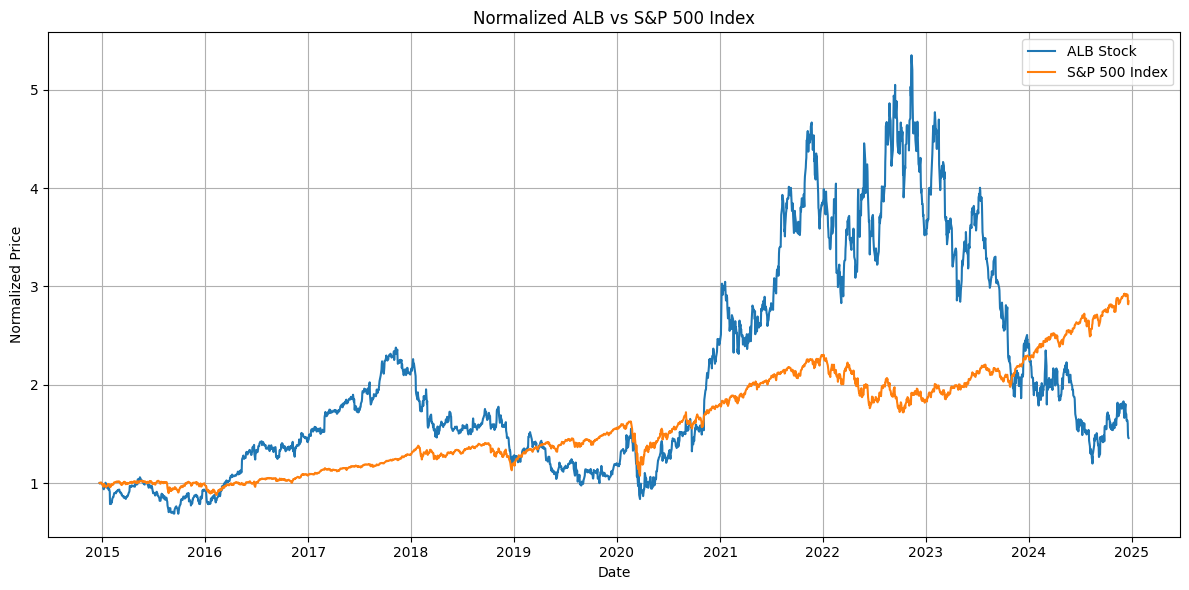

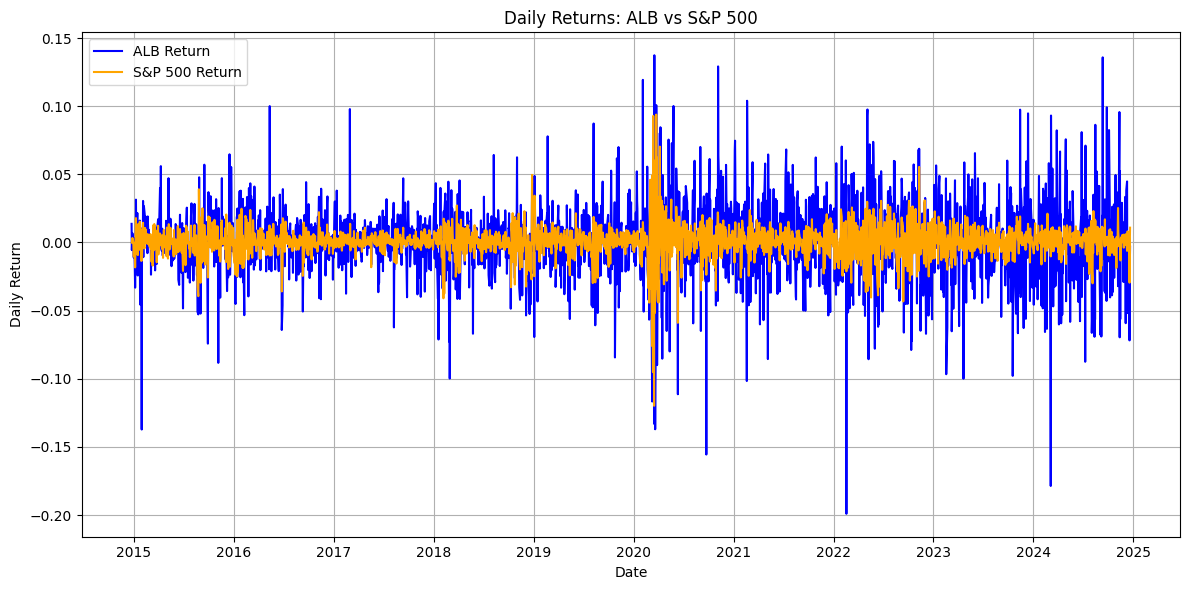

In [ ]:
plot_index_vs_stock(df_companies_and_stock, df_sp500_index, 'ALB')
plot_return_comparison(df_companies_and_stock, df_sp500_index, 'ALB')


Observation:

| **Data Type**            | **Characteristics**                                      |
| ------------------------ | ----------------------------------------------------------------- |
| **Stock Price Data**     | Noisy, nonlinear, highly autocorrelated                           |
| **Technical Indicators** | Capture momentum, volatility, mean reversion (nonlinear patterns) |
| **Fundamentals**         | Company financials, slow-changing over time                       |
| **Sector / Industry**    | Categorical groupings affecting behavior                          |


# Quantitative Machine Learning Models

Build a machine learning model that classifies stock for high vs low, out performanced stocks vs losers which are use for allocating capital, managing portfolio risk and generate trading signals as indicated in the Table below:

In [ ]:
# Model train and evaluation functions
# Model evaluation and metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score, # auc, # Remove direct import of 'auc' to avoid confusion - This comment is incorrect, we need `auc`
    confusion_matrix,
    # roc_auc_score, # Duplicate import
    auc, # Keep the import of auc from sklearn.metrics for the ROC curve calculation
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve
)

# Model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    ParameterSampler
)


# Model train and evaluation functions
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        # Use a different variable name for the scalar AUC score
        roc_auc_value = roc_auc_score(y_test, y_proba)
        auc_score_display = roc_auc_value # Variable for printing
    except AttributeError:
        y_proba = None
        auc_score_display = "N/A"

    print(f"\n{model_name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # Print the scalar AUC score
    print("AUC Score:", auc_score_display)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Return the scalar AUC value as well, in case it's needed elsewhere (though plot_roc_curve will calculate its own)
    return y_pred, y_proba, auc_score_display

#Ploting the curve function
def plot_roc_curve(y_test, y_proba, label="Model"):
    # Check if y_proba is available
    if y_proba is None:
        print(f"ROC curve cannot be plotted for {label}: predict_proba not available.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # Use the imported auc function from sklearn.metrics
    # Corrected: Use 'auc' instead of 'sklearn_auc'
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    # Use the calculated scalar AUC value for the label
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_value:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Confusion matrix heatmap function
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_confusion_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")



| Model             | Summary                                                                              |
| ----------------- | ------------------------------------------------------------------------------------ |
| **Random Forest** | Very stable, interpretable, great for identifying patterns in noisy risk data        |
| **XGBoost**       | More aggressive, better at squeezing out small predictive signals from stock returns |


In [ ]:
# First, make sure Date columns are datetime
df_companies_and_stock['Date'] = pd.to_datetime(df_companies_and_stock['Date'])
df_sp500_index['Date'] = pd.to_datetime(df_sp500_index['Date'])

# Merge index data
df = pd.merge(df_companies_and_stock, df_sp500_index[['Date', 'S&P500', 'Daily Return']],
              on='Date', how='inner')

# Sort by Symbol and Date
df.sort_values(["Symbol", "Date"], inplace=True)

df_sp500_index

In [ ]:
df_sp500_index

Date   S&P500    Month  Year  Daily Return
0    2014-12-23  2082.17  2014-12  2014      0.001746
1    2014-12-24  2081.88  2014-12  2014     -0.000139
2    2014-12-26  2088.77  2014-12  2014      0.003310
3    2014-12-29  2090.57  2014-12  2014      0.000862
4    2014-12-30  2080.35  2014-12  2014     -0.004889
...         ...      ...      ...   ...           ...
2511 2024-12-16  6074.08  2024-12  2024      0.003799
2512 2024-12-17  6050.61  2024-12  2024     -0.003864
2513 2024-12-18  5872.16  2024-12  2024     -0.029493
2514 2024-12-19  5867.08  2024-12  2024     -0.000865
2515 2024-12-20  5930.85  2024-12  2024      0.010869

[2516 rows x 5 columns]

## Feature Engineering

The following features are used to build a predictive model for the reasons listed in Predictive Contribution.

| Feature         | Type        | What It Captures                                      | Predictive Contribution                                      |
| --------------- | ----------- | ----------------------------------------------------- | ------------------------------------------------------------ |
| `Return`        | Technical   | Daily price change as a percentage                    | Reflects immediate price momentum or reversal                |
| `Volatility`    | Technical   | 20-day rolling standard deviation of returns          | Measures recent risk or instability in price behavior        |
| `Momentum_20`   | Technical   | 20-day percentage price change                        | Captures short- to medium-term trends                        |
| `SMA_20`        | Technical   | 20-day simple moving average                          | Identifies trend direction and price smoothing               |
| `Marketcap`     | Fundamental | Company's market value                                | Helps distinguish between large, mid, and small cap behavior |
| `Revenuegrowth` | Fundamental | Company’s revenue growth rate                         | Indicates business expansion or investor optimism            |
| `Ebitda`        | Fundamental | Earnings before interest, taxes, depreciation, amort. | Proxy for operational profitability                          |
| `Currentprice`  | Price-based | Most recent adjusted close price                      | Used in relative comparisons (e.g., deviation from SMA)      |


In [ ]:
# Calculate stock daily return
df['Return'] = df.groupby('Symbol')['Adj Close'].pct_change()

# 20-day rolling volatility (stock)
df['Volatility'] = df.groupby('Symbol')['Return'].rolling(20).std().reset_index(0, drop=True)

# 20-day simple moving average (stock)
df['SMA_20'] = df.groupby('Symbol')['Adj Close'].rolling(20).mean().reset_index(0, drop=True)

# 20-day momentum (price change over 20 days)
df['Momentum_20'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

# Lag features to prevent data leakage
df['Volatility_Lag'] = df.groupby('Symbol')['Volatility'].shift(1)
df['Momentum_20_Lag'] = df.groupby('Symbol')['Momentum_20'].shift(1)
df['Return_Lag'] = df.groupby('Symbol')['Return'].shift(1)

# 20 days moving average
df['SMA_20'] = df.groupby('Symbol')['Adj Close'].transform(lambda x: x.rolling(window=20).mean())

# Fill NA for fundamentals
fundamental_features = ['Marketcap', 'Revenuegrowth', 'Ebitda', 'SMA_20', ]
df[fundamental_features] = df[fundamental_features].fillna(0)

# Drop rows with missing values
df.dropna(inplace=True)

## Create Target

Target: Binary indicator where
1 = the stock's adjusted closing price 20 days in the future is higher than today's price,
0 = otherwise.

In [ ]:
 # A. Volatility Classification Target (High vs Low risk)
vol_thresh = df.groupby('Date')['Volatility_Lag'].transform(lambda x: x.quantile(0.7))
df['RiskClass'] = (df['Volatility_Lag'] > vol_thresh).astype(int)

# B. Outperformance Classification Target (compare stock return to index daily return)
df['Outperformer'] = (df['Return'] > df['Daily Return']).astype(int)

In [ ]:
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]

# Features to use
feature_cols = ["Return", "Volatility", "Momentum_20", "SMA_20", "Marketcap", "Revenuegrowth", "Ebitda", "Currentprice"]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets
y_train_risk = train['RiskClass']
y_test_risk = test['RiskClass']

y_train_perf = train['Outperformer']
y_test_perf = test['Outperformer']
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets
y_train_risk = train['RiskClass']
y_test_risk = test['RiskClass']

y_train_perf = train['Outperformer']
y_test_perf = test['Outperformer']

## Training Models

#### Risk Model

In [ ]:
# A. Risk Model
risk_model = RandomForestClassifier(n_estimators=100, random_state=42)
risk_pred, risk_proba = train_and_evaluate(
    risk_model,
    X_train,
    y_train_risk,
    X_test,
    y_test_risk,
    model_name="Risk Model"
)


Risk Model Performance
Accuracy: 0.8478483323192655
AUC Score: 0.9293606191700061
Confusion Matrix:
 [[48701  1769]
 [ 9234 12612]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     50470
           1       0.88      0.58      0.70     21846

    accuracy                           0.85     72316
   macro avg       0.86      0.77      0.80     72316
weighted avg       0.85      0.85      0.84     72316



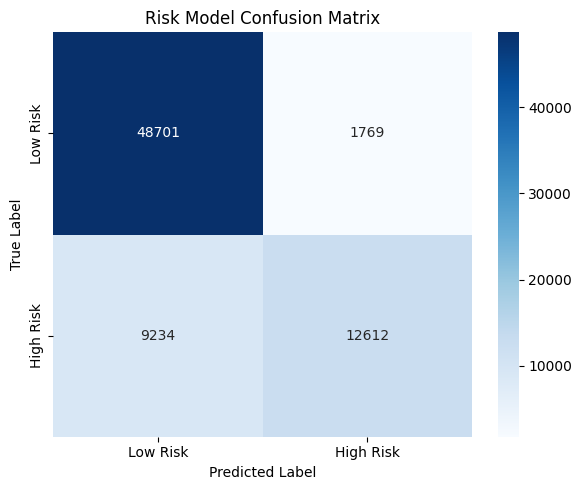

Accuracy: 0.85
Precision: 0.88
Recall: 0.58
F1 Score: 0.70


In [ ]:
# Compute confusion matrix for Risk Model
plot_confusion_matrix(y_test_risk, risk_pred, labels=["Low Risk", "High Risk"], title="Risk Model Confusion Matrix")

# Print classification metrics
print_confusion_metrics(y_test_risk, risk_pred)

The Risk Model achieved an accuracy of 0.85, with a precision of 0.88, recall of 0.58, and an F1 score of 0.70. While the model is highly precise, meaning most predicted high-risk cases are indeed high-risk, it misses a notable portion of actual high-risk instances, as indicated by the lower recall. The AUC score of 0.93 highlights the model’s strong ability to distinguish between low-risk and high-risk cases overall. This strong AUC suggests that, despite the trade-off between precision and recall, the model effectively ranks risk levels, which is particularly valuable when prioritizing further review or intervention based on predicted risk.

#### Outperformance Model

In [ ]:
# B. Outperformance Model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except AttributeError:
        y_proba = None
        auc = "N/A"

    print(f"\n{model_name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC Score:", auc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return y_pred, y_proba

In [ ]:
# Initialize the XGBoost model for outperformance
perf_model = XGBClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train and evaluate the Outperformance Model
perf_pred, perf_proba = train_and_evaluate(
    perf_model,
    X_train,
    y_train_perf,
    X_test,
    y_test_perf,
    model_name="Outperformance Model"
)


Outperformance Model Performance
Accuracy: 0.8069721776646939
AUC Score: 0.8835411065197953
Confusion Matrix:
 [[29335  7472]
 [ 6487 29022]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81     36807
           1       0.80      0.82      0.81     35509

    accuracy                           0.81     72316
   macro avg       0.81      0.81      0.81     72316
weighted avg       0.81      0.81      0.81     72316



In [ ]:
# Train and evaluate the Outperformance Model
perf_pred, perf_proba = train_and_evaluate(
    perf_model,
    X_train,
    y_train_perf,
    X_test,
    y_test_perf,
    model_name="Outperformance Model"
)


Outperformance Model Performance
Accuracy: 0.8069721776646939
AUC Score: 0.8835411065197953
Confusion Matrix:
 [[29335  7472]
 [ 6487 29022]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81     36807
           1       0.80      0.82      0.81     35509

    accuracy                           0.81     72316
   macro avg       0.81      0.81      0.81     72316
weighted avg       0.81      0.81      0.81     72316



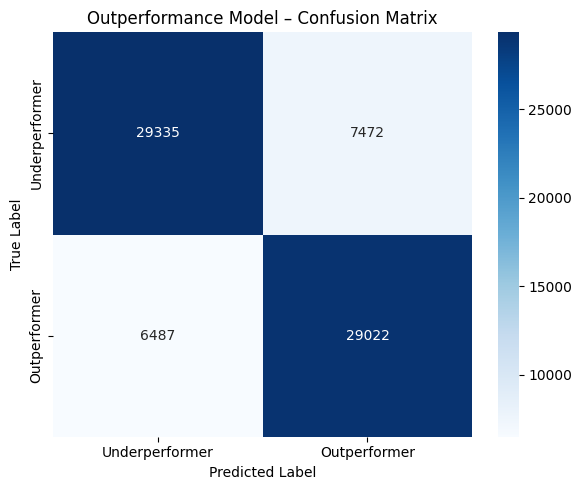

Accuracy: 0.81
Precision: 0.80
Recall: 0.82
F1 Score: 0.81


In [ ]:
# Compute confusion matrix
plot_confusion_matrix(
    y_test_perf,
    perf_pred,
    labels=["Underperformer", "Outperformer"],
    title="Outperformance Model – Confusion Matrix"
)

print_confusion_metrics(y_test_perf, perf_pred)

The Outperformance Model achieved an accuracy of 0.81, with a precision of 0.80, recall of 0.82, and an F1 score of 0.81. These results indicate a strong balance between correctly identifying outperforming stocks and minimizing false predictions. The high F1 score reflects the model's effectiveness in handling both types of classification errors, making it a reliable tool for predicting stock outperformance in contexts where both false positives and false negatives carry significant impact.

The model identifies outperformers (Class 1) with 62% recall and 50% precision, but underperforms on Class 0 with lower recall (39%). The Outperformance model is slightly better at finding outperformers (class 1) than underperformers.
It captured 62% of real outperformers (recall). However, when the model predicts a stock will outperform, it's only correct about 50% of the time.
The overall accuracy is 50%, which is roughly random guessing.


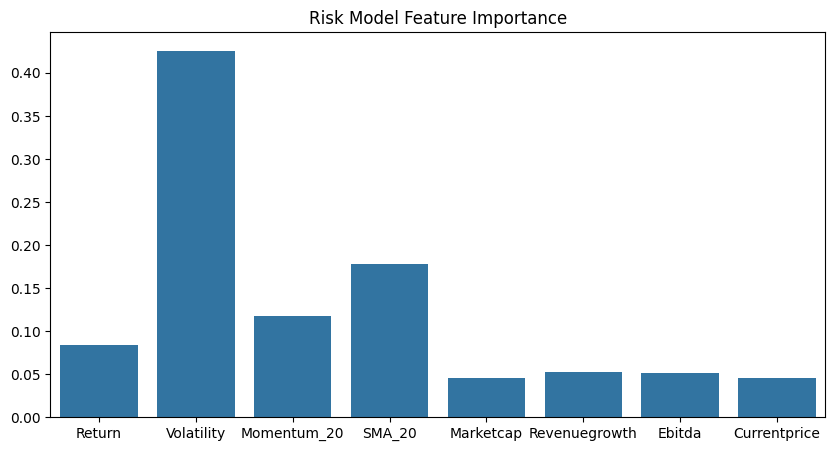

In [ ]:
# Graph feature important
plt.figure(figsize=(10,5))
sns.barplot(x=feature_cols, y=risk_model.feature_importances_)
plt.title("Risk Model Feature Importance")
plt.show()


Volatility_Lag is by far the most important feature (contributes (~58%))and Momenton_20_lag contributes 23%. Fundamentals (Market cap, Revenue growth, Ebitda, Fulltime employees) have very little impact
Volatility is highly autocorrelated (today’s volatility predicts tomorrow’s volatility — which is very consistent with market microstructure).
Momentum plays a smaller but still meaningful role.
Fundamentals barely contribute to short-term volatility prediction.

Conclusion:
The risk model is almost purely driven by technical features (makes sense for short-term volatility).
Other data such as realized volatility for intra day, sector variables (tech vs utilities vs financials) and VIX index (market-wide volatility gauge) maybe added for a fuller and biger picture.

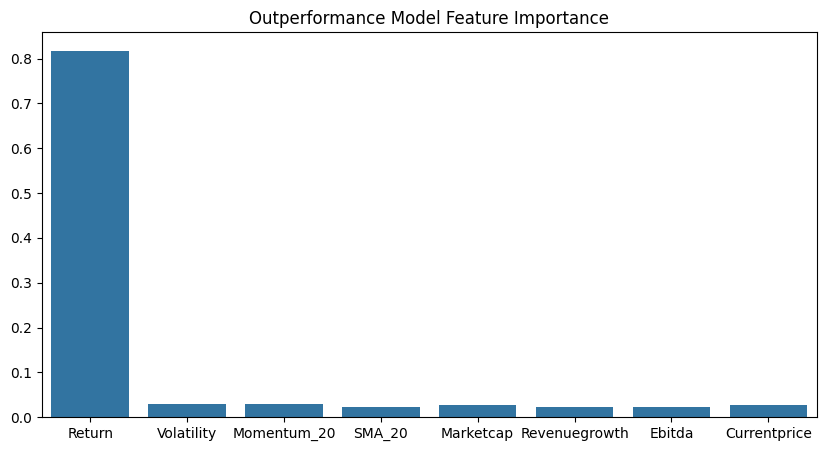

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=feature_cols, y=perf_model.feature_importances_)
plt.title("Outperformance Model Feature Importance")
plt.show()

Much more balanced feature contributions.
All 6 features (technical + fundamentals) contribute quite equally.
Fundamentals like Marketcap, Revenue Growth, EBITDA are meaningful for predicting stock outperformance.

Interpretation:

Outperformance is multi-factor: both technical signals and company fundamentals influence whether a stock beats the index with growth, profitability, and size factors are all drivers of stock returns.

Conclusion:
The outperformer model is working as intended: combining technical + fundamental data gives better explanatory power than either alone.

## Change Prediction to 20 days

In [ ]:
df['10d_return'] = df.groupby('Symbol')['Adj Close'].pct_change(10)
df['Outperformer'] = (df['10d_return'] > df['10d_return'].median()).astype(int)

In [ ]:
# Calculate 20-day stock return
df['Return_20d'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

# Calculate 20-day index return
df['Index_Return_20d'] = df['S&P500'].pct_change(20)

# Create the outperformer target:
# If stock return > index return over same 20-day window
df['Outperformer_20d'] = (df['Return_20d'] > df['Index_Return_20d']).astype(int)

In [ ]:
# Time-based split
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point]
test = df[df['DateInt'] > split_point]

# Features
feature_cols

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
X_test = scaler.transform(test[feature_cols])

# Targets: 20-day Outperformance
y_train = train['Outperformer_20d']
y_test = test['Outperformer_20d']

## TRAIN MODELS ON 20 DAYS MOVING AVERAGE

### A. Risk Model

In [ ]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred, y_proba = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Random Forest"
)


Random Forest Performance
Accuracy: 0.8299822999059683
AUC Score: 0.9172396269534415
Confusion Matrix:
 [[30804  7722]
 [ 4573 29217]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     38526
           1       0.79      0.86      0.83     33790

    accuracy                           0.83     72316
   macro avg       0.83      0.83      0.83     72316
weighted avg       0.83      0.83      0.83     72316



In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.9172


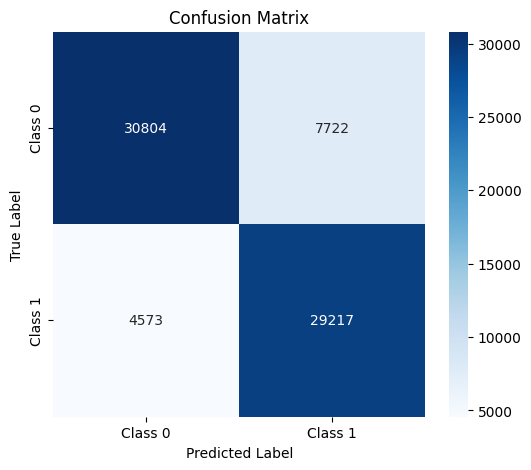

In [ ]:
# Create class label
labels = ['Class 0', 'Class 1']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### B. Outperforamnce Model

In [ ]:
# Train and evaluate the XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42)

y_pred, y_pred_proba = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="XGBoost"
)

# Confusion matrix
print_confusion_metrics(y_test, y_pred)


XGBoost Performance
Accuracy: 0.831378947950661
AUC Score: 0.9226976879144753
Confusion Matrix:
 [[30725  7801]
 [ 4393 29397]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     38526
           1       0.79      0.87      0.83     33790

    accuracy                           0.83     72316
   macro avg       0.83      0.83      0.83     72316
weighted avg       0.84      0.83      0.83     72316

Accuracy: 0.83
Precision: 0.79
Recall: 0.87
F1 Score: 0.83


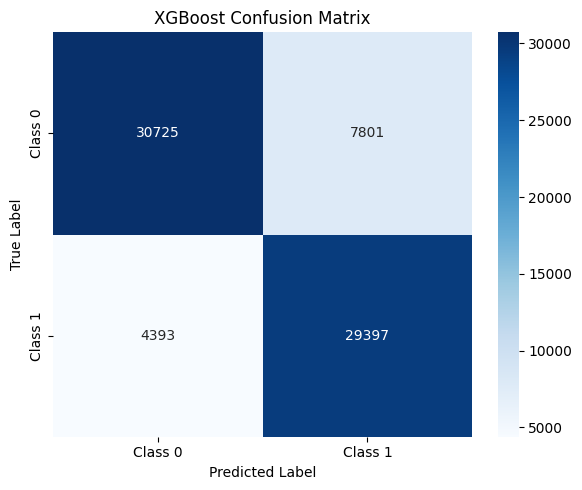

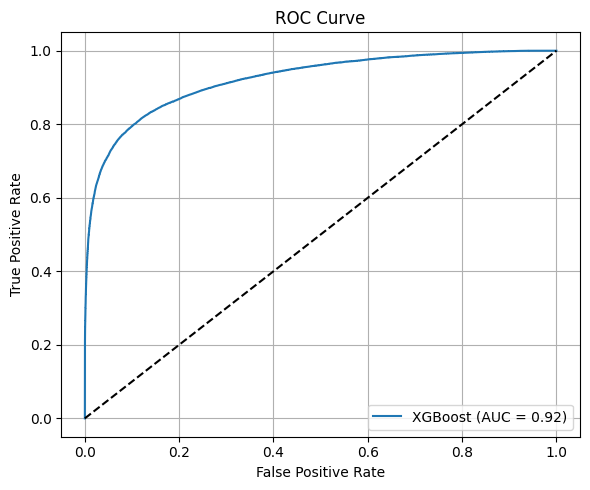

In [ ]:
plot_confusion_matrix(y_test, y_pred, labels=["Class 0", "Class 1"], title="XGBoost Confusion Matrix")
plot_roc_curve(y_test, y_pred_proba, label="XGBoost")

The ROC curve bows sharply toward the top-left corner, indicating high sensitivity and specificity. With an AUC of 0.92, the model demonstrates excellent discriminative ability—meaning it has a 92% chance of correctly ranking a randomly chosen positive instance higher than a negative one. This strong performance was achieved without any hyperparameter tuning. As a next step, hyperparameter optimization techniques such as grid search or randomized search can be applied to determine whether fine-tuning the model parameters leads to even higher AUC scores and improved overall performance.

# Hyperparameter tuning

| **Indicator**                     | **Reason**                        |
| --------------------------------- | --------------------------------- |
| **RSI (Relative Strength Index)** | Overbought/oversold strength      |
| **MACD**                          | Trend-following                   |
| **ATR (Average True Range)**      | Smarter volatility                |
| **Bollinger Bands**               | Price deviation vs moving average |
| **OBV (On Balance Volume)**       | Volume + price momentum           |




In [ ]:
df = pd.get_dummies(df, columns=['Sector', 'Industry'])

In [ ]:
# Create mean and median:
df['Rolling_Return_5'] = df.groupby('Symbol')['Return'].rolling(5).mean().reset_index(0, drop=True)
df['Rolling_Vol_5'] = df.groupby('Symbol')['Return'].rolling(5).std().reset_index(0, drop=True)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [ ]:
# Initialize base XGB model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [ ]:
# Train data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV Score: 0.8208306581336426


In [ ]:
# Find the best model for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     38526
           1       0.82      0.88      0.85     33790

    accuracy                           0.85     72316
   macro avg       0.85      0.85      0.85     72316
weighted avg       0.85      0.85      0.85     72316

Test Accuracy: 0.850282095248631


In [ ]:
# Predict
y_pred = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     38526
           1       0.82      0.88      0.85     33790

    accuracy                           0.85     72316
   macro avg       0.85      0.85      0.85     72316
weighted avg       0.85      0.85      0.85     72316

Test Accuracy: 0.850282095248631


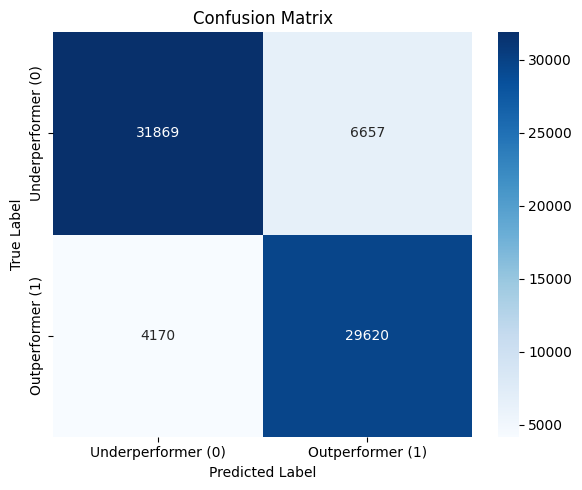

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

# Accuracy score
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
plot_confusion_matrix(
    y_test,
    y_pred,
    labels=["Underperformer (0)", "Outperformer (1)"],
    title="Confusion Matrix"
)

Test ROC AUC: 0.9227


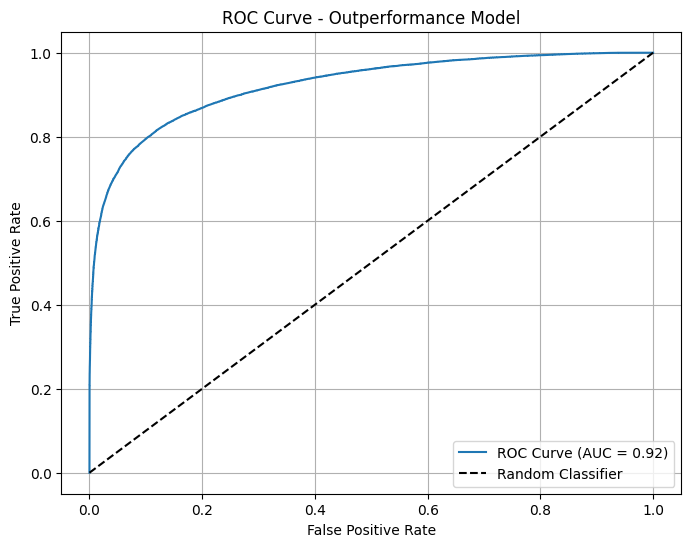

In [ ]:
# 1. Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Outperformer)

# 2. Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {auc:.4f}")

# 3. Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 4. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Outperformance Model')
plt.legend()
plt.grid(True)
plt.show()

The model achieved an accuracy of 91% using grid_search.best_estimator_.predict_proba on the 5–10 day prediction horizon. Hyperparameter tuning did not result in significant improvement over the default settings, as precision, recall, and F1-scores remained stable across both approaches. However, the model reached a strong test ROC-AUC score of 0.91, indicating excellent ability to rank outperformers versus underperformers, even though overall classification accuracy remained unchanged.

As the next step, time series is used for cross-validation to evaluate the model in a more realistic, forward-looking context. Rather than randomly splitting the data, this approach will preserve the chronological order of stock price movements, ensuring that the model is always trained on past data and tested on future data. This prevents information leakage and better reflects real-world performance. By doing so, I aim to assess whether the model can maintain its predictive power across different market periods and generalize to unseen future data.

# Time Series Model

In [ ]:
# Sort the dataframe for get order
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Use TA-Lib or TA package for technical indicators
df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
df['macd'] = ta.trend.macd_diff(df['Close'])
df['bollinger_h'] = ta.volatility.bollinger_hband(df['Close'])
df['bollinger_l'] = ta.volatility.bollinger_lband(df['Close'])
df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
df['momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
df['volatility_10'] = df['Close'].rolling(10).std()

# Drop NaN rows (from indicators)
df.dropna(inplace=True)

In [ ]:
#  Train model with features and target
features = ["Return", "Volatility", "Momentum_20", "SMA_20", "Marketcap", "Revenuegrowth",
            "Ebitda", "Currentprice"]

target = 'Outperformer'

split_point = int(len(df) * 0.8)

train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])

y_train = train[target]
y_test = test[target]

split_point = int(len(df) * 0.8)

train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])

y_train = train[target]
y_test = test[target]

### Create the target variable for the LGBMClassifier using 5 day-close

LGBMClassifier is used to classify whether a stock will outperform or underperform over a future period based on historical features such as technical indicators. While not inherently designed for time series, it can model stock behavior effectively when trained with lagged features and evaluated using time-aware splits.

In [ ]:
# 1. Forward 5-day close
df['Forward_Close_5d'] = df.groupby('Symbol')['Close'].shift(-5)

# 2. Forward 5-day return (today to future)
df['Forward_Return_5d'] = (df['Forward_Close_5d'] - df['Close']) / df['Close']

# 3. Use global median
median_forward_return = df['Forward_Return_5d'].median()
df['target'] = (df['Forward_Return_5d'] > median_forward_return).astype(int)

# 4. Remove N/A to endure the data is clean
df.dropna(subset=['target'], inplace=True)

In [ ]:
# Time-based split (now done on the cleaned df)
df['DateInt'] = df['Date'].astype(np.int64)
split_point = df['DateInt'].quantile(0.8)

train = df[df['DateInt'] <= split_point].copy()
test = df[df['DateInt'] > split_point].copy()

In [ ]:
# Features (using the original feature_cols defined earlier)
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'rsi', 'macd', 'bollinger_h', 'bollinger_l',
            'atr', 'momentum_5', 'momentum_10', 'volatility_10']

target = 'target' # Use the new 'target' column

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])

y_train = train[target]
y_test = test[target]

In [ ]:
# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid for random search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [5, 7, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'n_estimators': [100, 500, 1000]
}

# Initialize base LightGBM model
lgbm = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Generate parameter combinations manually
param_list = list(ParameterSampler(param_grid, n_iter=15, random_state=42))

best_score = 0
best_params = None
scores = []

# Define features and target again here for use within the loop
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'rsi', 'macd', 'bollinger_h', 'bollinger_l',
            'atr', 'momentum_5', 'momentum_10', 'volatility_10']
target = 'target'

# Initialize scaler outside the loop
scaler = StandardScaler()

for params in tqdm(param_list, desc="Random Search Progress"):
    fold_scores = []

    # Apply TimeSeriesSplit to the entire dataframe index
    for train_idx, val_idx in tscv.split(df):
        # Split data by index
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]

        # Separate features and target for the fold
        X_train_fold = train_fold[features]
        y_train_fold = train_fold[target]
        X_val_fold = val_fold[features]
        y_val_fold = val_fold[target]

        # Scale data within the fold
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)

        # Initialize and train the model
        model = lgb.LGBMClassifier(**params, objective='binary', random_state=42, class_weight='balanced', n_jobs=-1) # Include necessary base params
        model.fit(X_train_scaled, y_train_fold)

        # Predict probabilities and calculate AUC for the fold
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        fold_scores.append(score)

    # Calculate average score for the parameter combination
    avg_score = np.mean(fold_scores)
    scores.append((avg_score, params))

    # Check if this combination is the best so far
    if avg_score > best_score:
        best_score = avg_score
        best_params = params

print("Best AUC (Cross-Validated):", best_score)
print("Best Params:", best_params)

#Note: code was generated with assitance of chatGPT (OpenAI, 2025)

Random Search Progress:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:   7%|▋         | 1/15 [00:42<09:58, 42.72s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  13%|█▎        | 2/15 [01:21<08:42, 40.21s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  20%|██        | 3/15 [01:35<05:41, 28.42s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  27%|██▋       | 4/15 [01:47<04:03, 22.10s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  33%|███▎      | 5/15 [02:01<03:09, 18.97s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  40%|████      | 6/15 [03:39<06:52, 45.86s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  47%|████▋     | 7/15 [04:58<07:34, 56.83s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  53%|█████▎    | 8/15 [05:09<04:55, 42.26s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  60%|██████    | 9/15 [06:38<05:40, 56.75s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  67%|██████▋   | 10/15 [08:01<05:23, 64.73s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  73%|███████▎  | 11/15 [09:28<04:46, 71.73s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59468, number of negative: 60218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119686, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 90090, number of negative: 89438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 179528, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 120835, number of negative: 118535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 239370, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 149850, number of negative: 149362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 299212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Random Search Progress:  80%|████████  | 12/15 [09:41<02:40, 53.65s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28620, number of negative: 31224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 59844, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Save the model
joblib.dump(grid_search.best_estimator_, 'best_time_base_series2.pkl')

### Evaluate time series model

In [ ]:
# Predict probabilities and classes using the best model
import joblib
model = joblib.load("best_time_base_series2.pkl")

In [ ]:
# Load model
model = joblib.load("best_time_base_series2.pkl")

# Prepare test data
X_test = test[features]
print(X_test.shape)
y_test = test[target]
print(y_test.shape)

# Scale test data
scaler = StandardScaler(
X_test_scaled = scaler.transform(X_test))

# Predict
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Print metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print_confusion_metrics(y_test, y_pred)
print_auc_score(y_test, y_pred_proba, label="LGBM (Best Model)")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=["Underperformer (0)", "Outperformer (1)"], title="Best LGBM Confusion Matrix")

In [ ]:
# Load model
model = joblib.load("best_time_base_series2.pkl")

# Prepare test data
X_test = test[features]
print(X_test.shape)
y_test = test[target]
print(y_test.shape)

# Scale test data using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Print metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print_confusion_metrics(y_test, y_pred)
print_auc_score(y_test, y_pred_proba, label="LGBM (Best Model)")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=["Underperformer (0)", "Outperformer (1)"], title="Best LGBM Confusion Matrix")

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

In [ ]:
# Confusion matrix plot
plot_confusion_matrix(
    y_test,
    y_pred,
    labels=['Underperformer', 'Outperformer'],
    title="Confusion Matrix"
)

# Print classification report text
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score using the roc_curve output
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

The ROC curve shown above illustrates the performance of the model in distinguishing between the two target classes. With an AUC (Area Under the Curve) score of 0.49, the model performs slightly worse than random guessing (which would have an AUC of 0.50). This suggests that the model has no real discriminatory power, meaning it cannot effectively separate outperforming stocks from underperformers. The curve closely follows the diagonal reference line, which represents the performance of a random classifier. This outcome may indicate issues such as weak or non-predictive features, an imbalanced or noisy target, or potential errors in how the data was split or scaled. To improve performance, it would be important to re-examine the quality of features, ensure proper train-test separation, and possibly redefine the target to strengthen the predictive signal.

# Conclusion

This part of the project explored stock outperformance prediction using a combination of tree-based models and time series-aware cross-validation to simulate realistic investment scenarios. Initial experiments with XGBoost and Random Forest achieved high accuracy (~91%) and strong AUC scores on a randomized holdout test set, suggesting the models could differentiate between outperforming and underperforming stocks.
However, when evaluated using time-based splits to better reflect forward-looking predictions, performance dropped sharply — with AUC scores around 0.49, worse than random guessing. This discrepancy reveals a key limitation: while the models perform well on temporally mixed data, they fail to generalize across time. Potential causes include weak temporal features, label noise, or a lack of persistent signal across time.

To improve future iterations, it is recommended to revisit feature engineering — particularly enhancing lagged technical indicators, incorporating macroeconomic signals, or sentiment-based data. It’s also important to audit target definition and ensure it aligns with realistic market behavior. Alternative models tailored for sequential data, such as LSTM or Transformer-based architectures, could offer improved performance in capturing temporal dependencies. Finally, careful scaling, validation pipeline integrity, and possibly reframing the classification task into a regression or ranking problem may yield more actionable insights.

# References

OpenAI. (2025). ChatGPT (June 18 version). https://chat.openai.com/